In [1]:
! . .venv/bin/activate
! sstat -j $SLURM_JOB_ID 

JobID         MaxVMSize  MaxVMSizeNode  MaxVMSizeTask  AveVMSize     MaxRSS MaxRSSNode MaxRSSTask     AveRSS MaxPages MaxPagesNode   MaxPagesTask   AvePages     MinCPU MinCPUNode MinCPUTask     AveCPU   NTasks AveCPUFreq ReqCPUFreqMin ReqCPUFreqMax ReqCPUFreqGov ConsumedEnergy  MaxDiskRead MaxDiskReadNode MaxDiskReadTask  AveDiskRead MaxDiskWrite MaxDiskWriteNode MaxDiskWriteTask AveDiskWrite TRESUsageInAve TRESUsageInMax TRESUsageInMaxNode TRESUsageInMaxTask TRESUsageInMin TRESUsageInMinNode TRESUsageInMinTask TRESUsageInTot TRESUsageOutAve TRESUsageOutMax TRESUsageOutMaxNode TRESUsageOutMaxTask TRESUsageOutMin TRESUsageOutMinNode TRESUsageOutMinTask TRESUsageOutTot 
------------ ---------- -------------- -------------- ---------- ---------- ---------- ---------- ---------- -------- ------------ -------------- ---------- ---------- ---------- ---------- ---------- -------- ---------- ------------- ------------- ------------- -------------- ------------ --------------- --------------- 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load the data from model_data 
version = 'v0'
train = pd.read_csv(f'model_data/{version}/train.csv')
val = pd.read_csv(f'model_data/{version}/val.csv')
test = pd.read_csv(f'model_data/{version}/test.csv')

# Split the data into X and y
x_train = train.drop(columns=['causedPressure'])
y_train = train['causedPressure']

x_val = val.drop(columns=['causedPressure'])
y_val = val['causedPressure']

x_test = test.drop(columns=['causedPressure'])
y_test = test['causedPressure']

# "Guess no pressure on every play" Baseline Model

In [11]:
print(f"Model should have a better accuracy than {y_train.mean()} on train data")
print(f"Model should have a better accuracy than {1 - y_val.mean()} on val data")
print(f"Model should have a better accuracy than {1 - y_test.mean()} on test data")

Model should have a better accuracy than 0.5 on train data
Model should have a better accuracy than 0.696875 on val data
Model should have a better accuracy than 0.696945967110415 on test data


In [13]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
import numpy as np

# Train a DummyClassifier with uniform strategy
dummy_clf = DummyClassifier(strategy='uniform', random_state=0)
dummy_clf.fit(x_train, y_train)

# Generate predictions
y_pred = dummy_clf.predict(x_test)
y_pred_proba = dummy_clf.predict_proba(x_test)[:, 1]  # Probabilities for positive class

# Calculate metrics
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Calculate AUC-ROC (requires probabilities for positive class)
try:
    auc_roc = roc_auc_score(y_test, y_pred_proba)
except ValueError as e:
    auc_roc = 'N/A (not computable, no positive class in predictions)'

# Output metrics
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("AUC-ROC:", auc_roc)


F1 Score: 0.36964980544747084
Accuracy: 0.4925606891151135
AUC-ROC: 0.5


# Logistic Regression Baseline Model

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(x_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(x_test)

# Generate the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


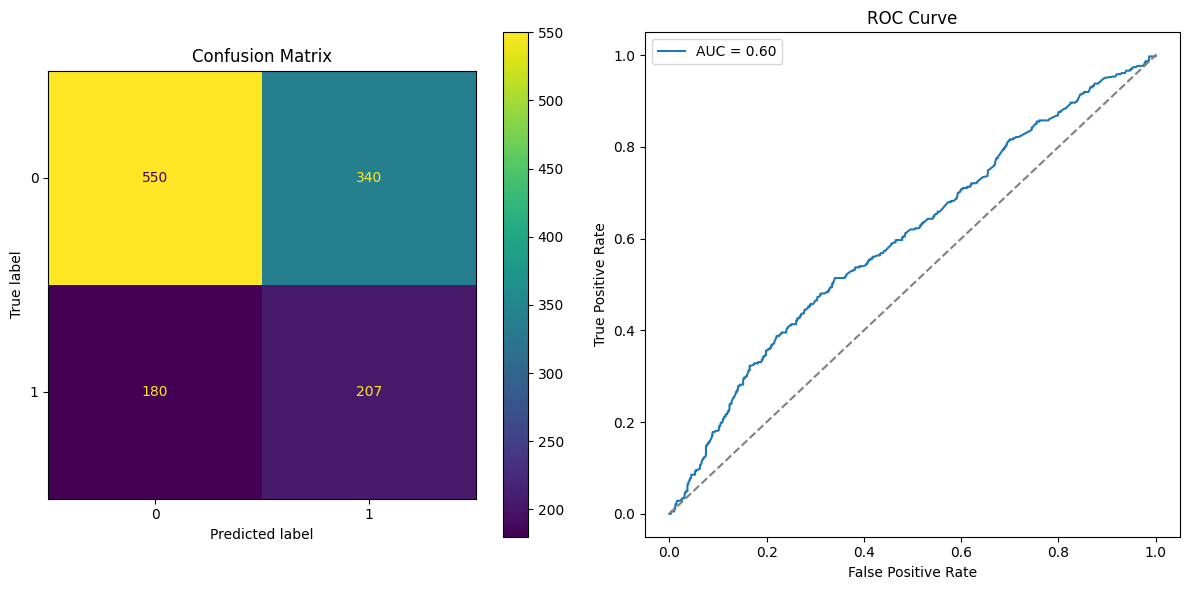

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0])
ax[0].set_title("Confusion Matrix")

# Compute and plot ROC curve
y_proba = log_reg.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

ax[1].plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC Curve")
ax[1].legend()

plt.tight_layout()
plt.show()
